# Entreno en 2500 pruebo en 20mil

In [1]:
import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc

In [2]:
import joblib
cpu = joblib.cpu_count()

## Funcion de ayuda

In [3]:
def to_float32(df):
    df = df.copy()
    df[X_columns] = df[X_columns].apply(pd.to_numeric, downcast='float')
    df = df[~df.Period_fit.isin([-np.inf, np.inf])]
    return df

def run_test(clf, tile, X_columns, y_column):
    tile = to_float32(tile)
    X_test = tile[X_columns].values
    y_test = tile[y_column].values
    
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)

    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    print metrics.classification_report(y_test, predictions)
    
    return Container({
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'y_test': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})

results = []

## Train 2.5K

In [4]:
sample = pd.read_pickle("data/ogle3_only/scaled/s2_5k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
train = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

Reescalamos la muestra de 20k con media y desvio del de 2.5k

In [5]:
skl = pickle.load(open("data/ogle3_only/scalers/scaler_2_5k.pkl"))

/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
sample = pd.read_pickle("data/ogle3_only/nonull/s20k.pkl.bz2")

sample[X_columns] = skl.transform(sample[X_columns])

sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
test = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
train_name, test_name = "b261", "b278"

print("Train {} - Test {}".format(train_name, test_name))

X_train = train[train_name][X_columns].values
y_train = train[train_name].cls.values

clf_small = RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu)
clf_small.fit(X_train, y_train)
result_small = run_test(clf_small, test[test_name], X_columns, "cls")
results.append({"train": train_name, "train_size": "small", "test": test_name, "result": result_small})

Train b261 - Test b278
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19929
           1       0.89      0.70      0.78       423

   micro avg       0.99      0.99      0.99     20352
   macro avg       0.94      0.85      0.89     20352
weighted avg       0.99      0.99      0.99     20352



In [8]:
train_name, test_name = "b278", "b261"

print("Train {} - Test {}".format(train_name, test_name))

X_train = train[train_name][X_columns].values
y_train = train[train_name].cls.values

clf_small = RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu)
clf_small.fit(X_train, y_train)
result_small = run_test(clf_small, test[test_name], X_columns, "cls")
results.append({"train": train_name, "train_size": "small", "test": test_name, "result": result_small})

Train b278 - Test b261
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.73      0.88      0.80       221

   micro avg       1.00      1.00      1.00     20193
   macro avg       0.87      0.94      0.90     20193
weighted avg       1.00      1.00      1.00     20193



## Train 5K

In [9]:
sample = pd.read_pickle("data/ogle3_only/scaled/s5k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
train = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

Reescalamos la muestra de 20k con media y desvio del de 5k

In [10]:
skl = pickle.load(open("data/ogle3_only/scalers/scaler_5k.pkl"))

In [11]:
sample = pd.read_pickle("data/ogle3_only/nonull/s20k.pkl.bz2")

sample[X_columns] = skl.transform(sample[X_columns])

sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
test = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
train_name, test_name = "b261", "b278"

print("Train {} - Test {}".format(train_name, test_name))

X_train = train[train_name][X_columns].values
y_train = train[train_name].cls.values

clf_small = RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu)
clf_small.fit(X_train, y_train)
result_small = run_test(clf_small, test[test_name], X_columns, "cls")
results.append({"train": train_name, "train_size": "mid", "test": test_name, "result": result_small})

Train b261 - Test b278
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19929
           1       0.92      0.69      0.79       423

   micro avg       0.99      0.99      0.99     20352
   macro avg       0.96      0.85      0.89     20352
weighted avg       0.99      0.99      0.99     20352



In [13]:
train_name, test_name = "b278", "b261"

print("Train {} - Test {}".format(train_name, test_name))

X_train = train[train_name][X_columns].values
y_train = train[train_name].cls.values

clf_small = RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu)
clf_small.fit(X_train, y_train)
result_small = run_test(clf_small, test[test_name], X_columns, "cls")
results.append({"train": train_name, "train_size": "mid", "test": test_name, "result": result_small})

Train b278 - Test b261
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.85      0.84      0.84       221

   micro avg       1.00      1.00      1.00     20193
   macro avg       0.92      0.92      0.92     20193
weighted avg       1.00      1.00      1.00     20193



## Train 20K

In [14]:
sample = pd.read_pickle("data/ogle3_only/scaled/s20k.pkl.bz2")

sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
test = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [15]:
train = test

In [16]:
train_name, test_name = "b261", "b278"

print("Train {} - Test {}".format(train_name, test_name))

X_train = train[train_name][X_columns].values
y_train = train[train_name].cls.values

clf_small = RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu)
clf_small.fit(X_train, y_train)
result_small = run_test(clf_small, test[test_name], X_columns, "cls")
results.append({"train": train_name, "train_size": "big", "test": test_name, "result": result_small})

Train b261 - Test b278
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19931
           1       0.97      0.58      0.73       423

   micro avg       0.99      0.99      0.99     20354
   macro avg       0.98      0.79      0.86     20354
weighted avg       0.99      0.99      0.99     20354



In [17]:
train_name, test_name = "b278", "b261"

print("Train {} - Test {}".format(train_name, test_name))

X_train = train[train_name][X_columns].values
y_train = train[train_name].cls.values

clf_small = RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu)
clf_small.fit(X_train, y_train)
result_small = run_test(clf_small, test[test_name], X_columns, "cls")
results.append({"train": train_name, "train_size": "big", "test": test_name, "result": result_small})

Train b278 - Test b261
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19972
           1       0.97      0.75      0.84       221

   micro avg       1.00      1.00      1.00     20193
   macro avg       0.98      0.87      0.92     20193
weighted avg       1.00      1.00      1.00     20193



## ROC!

In [18]:
r = results[-1]
r

{'result': <Container({'probabilities': <type 'numpy.ndarray'>, 'predictions': <type 'numpy.ndarray'>, 'thresh': <type 'numpy.ndarray'>, 'tpr': <type 'numpy.ndarray'>, 'fpr': <type 'numpy.ndarray'>, 'prec_rec_curve': <type 'tuple'>, 'confusion_matrix': <type 'numpy.ndarray'>, 'y_test': <type 'numpy.ndarray'>, 'roc_auc': <type 'numpy.float64'>})>,
 'test': 'b261',
 'train': 'b278',
 'train_size': 'big'}

In [19]:
rows = []
for r in results:
    rr = r["result"]
    new_row = {k:v for k, v in r.items() if k != "result"}
    new_row.update(
        recall=metrics.recall_score(rr.y_test, rr.predictions),
        precision=metrics.precision_score(rr.y_test, rr.predictions),
        AUC=rr.roc_auc)
    rows.append(new_row)


In [20]:
muestras = {"small": u"Pequeña", "mid": "Mediana", "big": "Grande"}
df = pd.DataFrame(rows)
df.columns = "AUC Prec Rec Entrenamiento Prueba Muestra".split()
df["Muestra"] = df.Muestra.apply(muestras.get)
df = df.set_index(["Muestra", "Entrenamiento", "Prueba"])
df = df["Prec Rec AUC".split()]
df

Prec       Rec       AUC
Muestra Entrenamiento Prueba                              
Pequeña b278          b261    0.888554  0.697400  0.986413
        b261          b278    0.734848  0.877828  0.988391
Mediana b278          b261    0.921384  0.692671  0.987358
        b261          b278    0.845455  0.841629  0.986646
Grande  b278          b261    0.968504  0.581560  0.984398
        b261          b278    0.970588  0.746606  0.986109

In [45]:
print df.to_latex(index=True, float_format='%.3f')

\begin{tabular}{lllrrr}
\toprule
       &      &      &  Prec &   Rec &   AUC \\
Muestra & Entrenamiento & Prueba &       &       &       \\
\midrule
Pequeña & b278 & b261 & 0.889 & 0.697 & 0.986 \\
       & b261 & b278 & 0.735 & 0.878 & 0.988 \\
Mediana & b278 & b261 & 0.921 & 0.693 & 0.987 \\
       & b261 & b278 & 0.845 & 0.842 & 0.987 \\
Grande & b278 & b261 & 0.969 & 0.582 & 0.984 \\
       & b261 & b278 & 0.971 & 0.747 & 0.986 \\
\bottomrule
\end{tabular}



In [ ]:
print df.to_latex

In [22]:
train_b261 = {
    u"{} vs Grande".format(muestras[r["train_size"]]): r["result"]
    for r in results if r["train"] == "b261"}
train_b278 = {
    u"{} vs Grande".format(muestras[r["train_size"]]): r["result"]
    for r in results if r["train"] == "b278"}

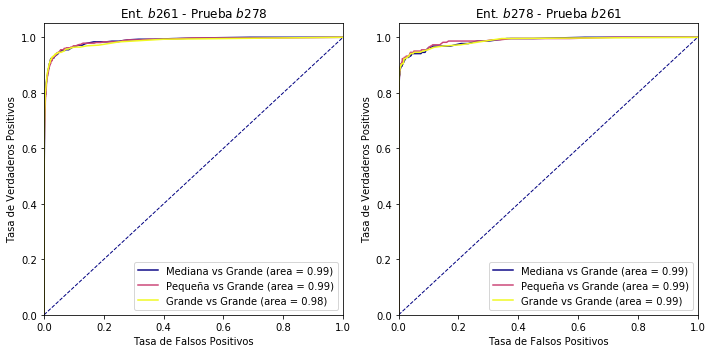

In [51]:
fig, (b261_plot, b278_plot) = plt.subplots(ncols=2)
fig.set_size_inches(10, 5)

roc(train_b261, ax=b261_plot)
roc(train_b278, ax=b278_plot)

b261_plot.set_title("Ent. $b261$ - Prueba $b278$")
b278_plot.set_title("Ent. $b278$ - Prueba $b261$")

plt.savefig("two_rocs.pdf")
plt.show()

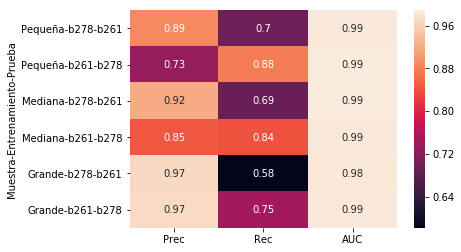

In [49]:
sns.heatmap(df, annot=True)

In [55]:
rr = results[2]["result"]

In [56]:
rr.fpr

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.01781324e-05,
         5.01781324e-05,   5.01781324e-05,   5.01781324e-05,
         5.01781324e-05,   5.01781324e-05,   1.50534397e-04,
         1.50534397e-04,